Código para o projeto/artigo mestrado - 2024

Instalando bibiotecas

In [1]:
%pip install tensorflow
%pip install tensorboardX
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install timm
%pip install pillow
%pip install cjm_pandas_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms torchtnt torcheval
%pip install torchmetrics
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Importando dependências necessárias

In [2]:
# Import Python Standard Library dependencies
#from copy import copy
#import datetime
#from glob import glob
import json
import math
#import multiprocessing
import os
from pathlib import Path
#import random
#import urllib.request
import timm
import csv
from utils.tools import del_file

# Import utility functions
#from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import get_img_files
#from cjm_psl_utils.core import download_file, file_extract
from cjm_pytorch_utils.core import set_seed, get_torch_device
#from cjm_torchvision_tfms.core import ResizeMax, PadSquare

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import pandas module for data manipulation
import pandas as pd

# Do not truncate the contents of cells and display all rows and columns
pd.set_option('max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

# Import PIL for image manipulation
from PIL import Image

# Import timm library
import timm

# Import PyTorch dependencies
import torch
import torch.nn as nn
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torch.utils.data import DataLoader

import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2  as transforms
#from torchvision.transforms.v2 import functional as TF
from torchvision import datasets

import torchvision.models as models

#from torchtnt.utils import get_module_summary
from torcheval.metrics import MulticlassAccuracy
#from torch import tensor

from tensorboardX import SummaryWriter


# Import tqdm for progress bar
from tqdm.auto import tqdm

c:\Users\intel\Anaconda3\envs\mestradodouglas\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

Defining the class for training and test

In [4]:
class training_class_models():
    def __init__(self,program_path,image_path_train,image_path_val,image_path_test,\
        model_name,lr,epochs,img_size):
        self.seed = 1234
        set_seed(self.seed)
        torch.cuda.set_device(1)
        self.device = get_torch_device()        
        self.dtype = torch.float32        
        self.model_name = model_name
        self.lr = lr
        self.epochs = epochs
        self.img_size = img_size        
        print(f"device is:{self.device}")        

        self.program_path = Path(program_path)
        self.image_path_train = Path(image_path_train)
        self.image_path_val = Path(image_path_val)
        self.image_path_test = Path(image_path_test)                
                
        #tensorboard configuration        
        self.writer = SummaryWriter(f"runs/{model_name}")
    
    def show_images_stats(self):
        
        img_folder_paths_train = [folder_train for folder_train in self.image_path_train.iterdir() if folder_train.is_dir()]
        img_folder_paths_val = [folder_val for folder_val in self.image_path_val.iterdir() if folder_val.is_dir()]

        # Get a list of all image file paths from the image folders
        class_file_paths_train = [get_img_files(folder) for folder in img_folder_paths_train]
        class_file_paths_val = [get_img_files(folder) for folder in img_folder_paths_val]

        # Get the number of samples for each image class
        class_counts_dict_train = {folder[0].parent.name:len(folder) for folder in class_file_paths_train}
        class_counts_dict_val = {folder[0].parent.name:len(folder) for folder in class_file_paths_val}

        # Get all image files in the 'img_dir' directory
        img_paths_train = [
            file
            for folder in class_file_paths_train # Iterate through each image folder
            for file in folder # Get a list of image files in each image folder
        ]
        
        # Get all image files in the 'img_dir' directory
        img_paths_val = [
            file
            for folder in class_file_paths_val # Iterate through each image folder
            for file in folder # Get a list of image files in each image folder
        ]
        
        ordered_classes_names = [
            os.path.basename(folder)
            for folder in self.image_path_train.iterdir() if folder.is_dir()
        ]    

        index = [
            i for i in range(0,len(ordered_classes_names))
        ]
        
        #create the mapping from the labels in train directory
        self.labels_map = dict(zip(index,ordered_classes_names))

        # Print the number of image files
        print(f"Number of train Images: {len(img_paths_train)}")
        
        # Print the number of image files
        print(f"Number of val Images: {len(img_paths_val)}")
        
        # Get a list of unique labels
        self.class_names = list(class_counts_dict_train.keys())

        # Display the labels and the corresponding number of samples using a Pandas DataFrame
        class_counts_train = pd.DataFrame.from_dict({'Count':class_counts_dict_train})        
    
        # Display the labels and the corresponding number of samples using a Pandas DataFrame
        class_counts_val = pd.DataFrame.from_dict({'Count':class_counts_dict_val})
        return class_counts_dict_train, class_counts_dict_val
    
    def data_preprocessing(self):
        self.dataset_name = 'rockdataset'
        
        train_transforms = transforms.Compose([
            transforms.RandomRotation((0, 180)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            #transforms.CenterCrop(700),  # center area for classification
            transforms.Resize([self.img_size, self.img_size]),
            transforms.ColorJitter(brightness=0.15, contrast=0.3, saturation=0.3, hue=0.06),
            transforms.ToTensor()
        ])

        val_transforms = transforms.Compose([    
            #transforms.CenterCrop(700),  # center area for classification
            transforms.Resize([self.img_size, self.img_size]),    
            transforms.ToTensor()
        ])
        
        train_data = datasets.ImageFolder(self.image_path_train,transform=train_transforms)
        val_data = datasets.ImageFolder(self.image_path_val,transform=val_transforms)        
        
        # self.labels_map = {
        #     0:  "granite-blackswan",            
        #     1:  "marble-shadow",            
        #     2:  "quartzite-oceanblue",
        #     3:  "quartzite-patagonia"            
        # }
        
        # self.labels_map = {
        #     0:  "granite-blackswan",
        #     1:  "granite-lucyinthesky",
        #     2:  "granite-nevascawhite",
        #     3:  "marble-dolomite-brancoparana",
        #     4:  "marble-dolomite-calacata",
        #     5:  "marble-shadow",
        #     6:  "quartzite-biancosuperiore",
        #     7:  "quartzite-oceanblue",
        #     8:  "quartzite-patagonia",
        #     9:  "quartzite-silvermoon",
        #     10: "quartzite-tajmahal",
        #     11: "quartzite-volupia"
        # } 
        
        self.train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
        self.val_dataloader = DataLoader(val_data, batch_size=32)        

    def load_pretrained_model(self):
        
        if (self.model_name[0:6] == 'ResNet'):
            if(self.model_name == "ResNet50"):
                self.model = models.resnet50(pretrained=True)
            elif(self.model_name == "ResNet101"):
                self.model = models.resnet101(pretrained=True)
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, len(self.labels_map))                
        else:
            self.model = timm.create_model(self.model_name, pretrained=True, num_classes=len(self.labels_map))

        # Set the device and data type for the model
        self.model = self.model.to(device=self.device, dtype=self.dtype)

        # Add attributes to store the device and model name for later reference
        self.model.device = self.device
        self.model.name = self.model_name
        print(f"model {self.model_name} loaded")
    
    def makedir_to_save_model(self):        
        # Create a directory to store the checkpoints if it does not already exist
        checkpoint_dir = self.program_path/f"models/{self.model_name}"        

        # Create the checkpoint directory if it does not already exist
        checkpoint_dir.mkdir(parents=True, exist_ok=True)

        # The model checkpoint path
        self.checkpoint_path = checkpoint_dir/f"{self.model_name}.pth"

        # Set file path
        class_labels_path = checkpoint_dir/f"{self.dataset_name}-classes.json"

        # Save class labels in JSON format
        with open(class_labels_path, "w") as write_file:
            json.dump(self.labels_map, write_file)        
    
    def train_and_val(self):
        
        # Function to run a single training/validation epoch
        def run_epoch(model, dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch_id, is_training):
            # Set model to training mode if 'is_training' is True, else set to evaluation mode
            model.train() if is_training else model.eval()

            # Reset the performance metric
            metric.reset()
            # Initialize the average loss for the current epoch
            epoch_loss = 0
            # Initialize progress bar with total number of batches in the dataloader
            progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")

            # Iterate over data batches
            for batch_id, (inputs, targets) in enumerate(dataloader):
                # Move inputs and targets to the specified device (e.g., GPU)
                inputs, targets = inputs.to(device), targets.to(device)

                # Enables gradient calculation if 'is_training' is True
                with torch.set_grad_enabled(is_training):
                    # Automatic Mixed Precision (AMP) context manager for improved performance
                    with autocast(torch.device(device).type):
                        outputs = model(inputs) # Forward pass
                        loss = torch.nn.functional.cross_entropy(outputs, targets) # Compute loss

                # Update the performance metric
                metric.update(outputs.detach().cpu(), targets.detach().cpu())

                # If in training mode
                if is_training:
                    if scaler:
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        old_scaler = scaler.get_scale()
                        scaler.update()
                        new_scaler = scaler.get_scale()
                        if new_scaler >= old_scaler:
                            lr_scheduler.step()
                    else:
                        loss.backward()
                        optimizer.step()
                        lr_scheduler.step()

                    optimizer.zero_grad()

                loss_item = loss.item()
                epoch_loss += loss_item
                
                # Update progress bar
                progress_bar.set_postfix(accuracy=metric.compute().item(),
                                        loss=loss_item,
                                        avg_loss=epoch_loss/(batch_id+1),
                                        lr=lr_scheduler.get_last_lr()[0] if is_training else "")
                progress_bar.update()

                # If loss is NaN or infinity, stop training
                if is_training:
                    stop_training_message = f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."
                    assert not math.isnan(loss_item) and math.isfinite(loss_item), stop_training_message
            
            #write in tensorboard
            if self.writer is not None:                
                if(is_training):
                    self.writer.add_scalar("Train/loss",float(epoch_loss),epoch_id + 1)
                    self.writer.add_scalar("Train/ACC",float(metric.compute().item()),epoch_id + 1)
                else:
                    self.writer.add_scalar("Val/loss",float(epoch_loss),epoch_id + 1)
                    self.writer.add_scalar("Val/ACC",float(metric.compute().item()),epoch_id + 1)
            
            progress_bar.close()
            if self.writer is not None:                
                self.writer.close()
            
            return epoch_loss / (batch_id + 1)
        
        def optimizer_lr_scheduler_metrics():
            # AdamW optimizer; includes weight decay for regularization
            optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, eps=1e-3)

            # Learning rate scheduler; adjusts the learning rate during training
            lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                            max_lr=self.lr,
                                                            total_steps=self.epochs*len(self.train_dataloader))

            # Performance metric: Multiclass Accuracy
            metric = MulticlassAccuracy()
            
            return optimizer, lr_scheduler, metric
        
        def train_loop(model, train_dataloader, valid_dataloader, optimizer, metric, lr_scheduler, device, epochs, checkpoint_path, use_scaler=False):
            # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
            scaler = GradScaler() if device.type == 'cuda' and use_scaler else None
            best_loss = float('inf')

            # Iterate over each epoch
            for epoch in tqdm(range(epochs), desc="Epochs"):
                # Run training epoch and compute training loss
                train_loss = run_epoch(model, train_dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch, is_training=True)
                # Run validation epoch and compute validation loss
                with torch.no_grad():
                    valid_loss = run_epoch(model, valid_dataloader, None, metric, None, device, scaler, epoch, is_training=False)

                # If current validation loss is lower than the best one so far, save model and update best loss
                if valid_loss < best_loss:
                    best_loss = valid_loss
                    metric_value = metric.compute().item()
                    torch.save(model.state_dict(), checkpoint_path)

                    training_metadata = {
                        'epoch': epoch,
                        'train_loss': train_loss,
                        'valid_loss': valid_loss,
                        'metric_value': metric_value,
                        'learning_rate': lr_scheduler.get_last_lr()[0],
                        'model_architecture': model.name
                    }

                    # Save best_loss and metric_value in a JSON file
                    with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
                        json.dump(training_metadata, f)
                    
                    

            # If the device is a GPU, empty the cache
            #if device.type != 'cpu':
            if str(device) != 'cpu':
                getattr(torch, device.type).empty_cache()
                print(f"memory released in device {device}")
        
        optimizer, lr_scheduler, metric = optimizer_lr_scheduler_metrics()
        
        train_loop(model=self.model,
           train_dataloader=self.train_dataloader,
           valid_dataloader=self.val_dataloader,
           optimizer=optimizer,
           metric=metric,
           lr_scheduler=lr_scheduler,
           device=torch.device(self.device),
           epochs=self.epochs,
           checkpoint_path=self.checkpoint_path,
           use_scaler=True)
        
    def test_model(self,saved_model=False):                
        
        checkpoint_dir = self.program_path/f"models/{self.model_name}"
        checkpoint_path = checkpoint_dir/f"{self.model_name}.pth"
            
        def load_model_and_test():
            #alternating GPU
            torch.cuda.set_device(1)
            self.device = get_torch_device()
            
            test_transforms = transforms.Compose([    
            #transforms.CenterCrop(700),  # center area for classification
            transforms.Resize([self.img_size, self.img_size]),    
            transforms.ToTensor()
            ])
            
            test_data = datasets.ImageFolder(self.image_path_test,transform=test_transforms)
            test_dataloader = DataLoader(test_data, batch_size=32)        
                                            
            if(saved_model):    
                self.model.load_state_dict(torch.load(checkpoint_path))
            
            # Set the device and data type for the model
            self.model = self.model.to(device=self.device, dtype=self.dtype)
            
            # Setting the model to evaluate
            self.model.eval()
            
            #all_inputs = torch.empty((0, 3, self.img_size, self.img_size), dtype=torch.float32).to(self.device)
            all_preds = torch.empty((0, len(self.labels_map)), dtype=torch.float32).to(self.device)
            all_targets = torch.empty((0), dtype=torch.float32).to(self.device)
                        
            with torch.no_grad():
                # Iterate over test data
                for batch_id, (inputs, targets) in enumerate(test_dataloader):
                    # Move inputs and targets to the specified device (e.g., GPU)
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    preds = self.model(inputs)                    
                    all_preds = torch.cat((all_preds,preds))
                    #all_inputs = torch.cat((all_inputs,inputs))
                    all_targets = torch.cat((all_targets,targets))                            
            
            #if torch.device(self.device) != 'cpu':
            if str(self.device) != 'cpu':
                getattr(torch, self.device).empty_cache()
                print(f"memory released in device {self.device} - test phase")
            
            
            return all_targets, all_preds
            #return all_inputs, all_targets, all_preds
        
        def compute_metrics(targets, preds):
            from torchmetrics.classification import MulticlassConfusionMatrix
            from torchmetrics.classification import MulticlassAccuracy
            from torchmetrics.classification import MulticlassF1Score
            import seaborn as sns
            
            #inputs = inputs.detach().cpu() 
            targets = targets.detach().cpu()
            preds = preds.detach().cpu()
            metric = MulticlassConfusionMatrix(len(self.labels_map))
            cm = metric(preds, targets)            
            acc = MulticlassAccuracy(len(self.labels_map))
            acc(preds, targets)
            acc = acc.compute().item()            
            f1score = MulticlassF1Score(len(self.labels_map))
            f1score(preds, targets)
            f1score = f1score.compute().item()
            
            figurecm = plt.figure(figsize=(6,6))
            sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
            plt.ylabel('Actual label');
            plt.xlabel('Predicted label');            
            all_sample_title = 'Confusion Matrix - '+self.model_name+ '\n acc: %.6f' % (acc)+' F1: %.6f' % (f1score)
            plt.title(all_sample_title, size = 9);
            figurecm.savefig(Path(checkpoint_path.parent/'confusionmatrix.jpg'))
                        
            preds_target = torch.argmax(preds, dim=1)
            
            idx = np.arange(len(preds_target))
            err = idx[preds_target != targets]            
            #print(err)
            if(len(err)>5):
                total = 5
            else:
                total = len(err)
            
            #X_err = inputs[err][0:total]
            y_err = targets[err][0:total]
            p_err = preds_target[err][0:total]            
            
            #figure_show_erros = plt.figure(figsize=(8,3))
            #plt.title("Sample Prediction erros - "+self.model_name)
            #plt.axis("off")          
            #for index, (image, label, pred) in enumerate(zip(X_err, y_err, p_err)):
            #    plt.subplot(1, len(p_err), index + 1)
            #    plt.imshow(image.squeeze().permute(1, 2, 0), cmap="gray")
            #    plt.axis("off")
            #    plt.title(f'ERROR (T|P) \n T: %s \n P: %s' % (self.labels_map[label.item()], self.labels_map[pred.item()]), fontsize = 6)
            #plt.show()
            #figure_show_erros.savefig(Path(checkpoint_path.parent/'sample-pred-errors.jpg'))
            #plt.close(figure_show_erros)
            
            save_data_test(acc,f1score)
        
        def save_data_test(test_acc, test_f1score):
            row = [self.model_name, test_acc, test_f1score]
    
            with open('./metrics.csv', 'a',encoding='UTF8', newline='') as f:        
                writercsv = csv.writer(f)
                writercsv.writerow(row)
                f.close()
                
        #inputs, targets, preds = load_model_and_test()
        targets, preds = load_model_and_test()
        compute_metrics(targets, preds)
        

    def initiate(self):
       self.show_images_stats()
       self.data_preprocessing()
       self.load_pretrained_model()
       self.makedir_to_save_model()
       self.train_and_val()
       self.test_model()
    
    def test_with_saved_model(self):
        is_saved_model = True
        self.show_images_stats()
        self.data_preprocessing()
        self.load_pretrained_model()        
        self.test_model(is_saved_model)   



device is:cuda
Number of train Images: 7011
Number of val Images: 1460


c:\Users\intel\Anaconda3\envs\mestradodouglas\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


model vit_base_patch16_384 loaded


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\intel\Anaconda3\envs\mestradodouglas\lib\site-packages\timm\models\vision_transformer.py:91: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(
Epochs: 100%|██████████| 30/30 [4:13:29<00:00, 506.99s/it]


memory released in device cuda
memory released in device cuda - test phase
device is:cuda
Number of train Images: 7011
Number of val Images: 1460


c:\Users\intel\Anaconda3\envs\mestradodouglas\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


model inception_v3 loaded


Epochs: 100%|██████████| 30/30 [1:55:03<00:00, 230.10s/it]


memory released in device cuda
memory released in device cuda - test phase
device is:cuda
Number of train Images: 7011
Number of val Images: 1460


c:\Users\intel\Anaconda3\envs\mestradodouglas\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
c:\Users\intel\Anaconda3\envs\mestradodouglas\lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


model xception loaded


Epochs: 100%|██████████| 30/30 [2:31:06<00:00, 302.22s/it]


memory released in device cuda
memory released in device cuda - test phase
device is:cuda
Number of train Images: 7011
Number of val Images: 1460


c:\Users\intel\Anaconda3\envs\mestradodouglas\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


model vgg16 loaded


Epochs: 100%|██████████| 30/30 [2:43:31<00:00, 327.04s/it]


memory released in device cuda
memory released in device cuda - test phase
device is:cuda
Number of train Images: 7011
Number of val Images: 1460


c:\Users\intel\Anaconda3\envs\mestradodouglas\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


model vgg19 loaded


Epochs: 100%|██████████| 30/30 [2:55:35<00:00, 351.18s/it]


memory released in device cuda
memory released in device cuda - test phase
device is:cuda
Number of train Images: 7011
Number of val Images: 1460


c:\Users\intel\Anaconda3\envs\mestradodouglas\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


model visformer_small loaded


Epochs: 100%|██████████| 30/30 [50:53<00:00, 101.79s/it]


memory released in device cuda
memory released in device cuda - test phase
device is:cuda
Number of train Images: 7011
Number of val Images: 1460


c:\Users\intel\Anaconda3\envs\mestradodouglas\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
c:\Users\intel\Anaconda3\envs\mestradodouglas\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\intel\Anaconda3\envs\mestradodouglas\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model ResNet50 loaded


Epochs: 100%|██████████| 30/30 [1:48:30<00:00, 217.02s/it]


memory released in device cuda
memory released in device cuda - test phase
device is:cuda
Number of train Images: 7011
Number of val Images: 1460


c:\Users\intel\Anaconda3\envs\mestradodouglas\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
c:\Users\intel\Anaconda3\envs\mestradodouglas\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\intel\Anaconda3\envs\mestradodouglas\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model ResNet101 loaded


Epochs: 100%|██████████| 30/30 [2:11:03<00:00, 262.13s/it]


memory released in device cuda
memory released in device cuda - test phase
device is:cuda
Number of train Images: 7011
Number of val Images: 1460


c:\Users\intel\Anaconda3\envs\mestradodouglas\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


model densenet121 loaded


Epochs: 100%|██████████| 30/30 [47:43<00:00, 95.47s/it]


memory released in device cuda
memory released in device cuda - test phase
device is:cuda
Number of train Images: 7011
Number of val Images: 1460


c:\Users\intel\Anaconda3\envs\mestradodouglas\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


model densenet169 loaded


Epochs: 100%|██████████| 30/30 [51:54<00:00, 103.83s/it]


memory released in device cuda
memory released in device cuda - test phase


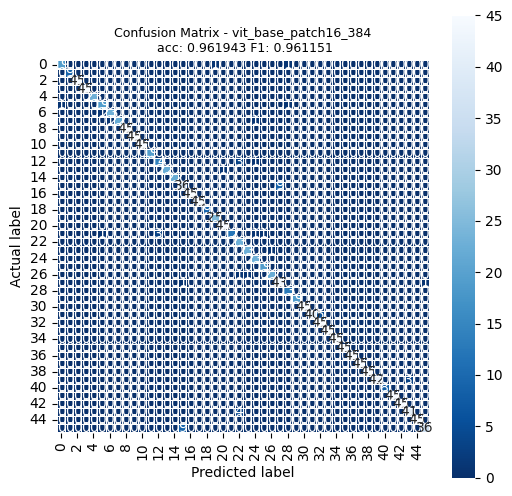

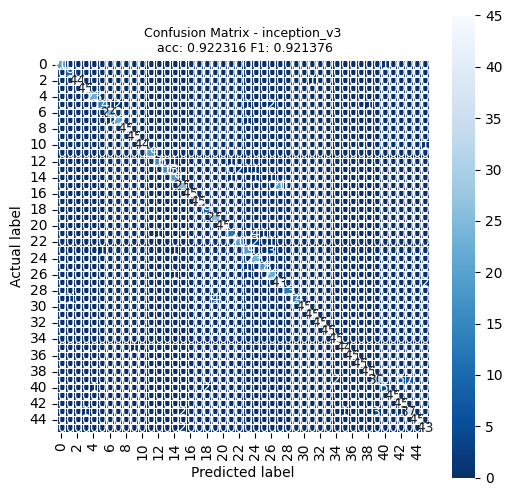

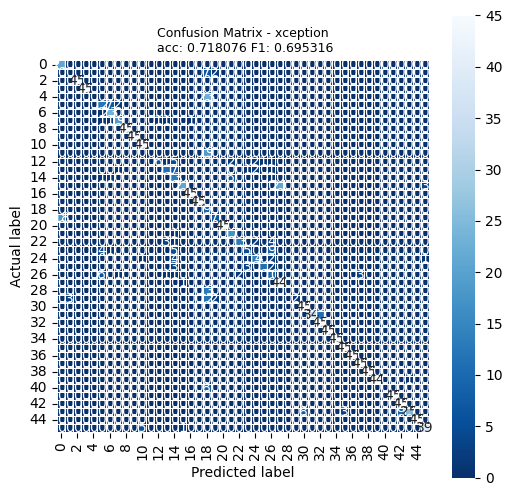

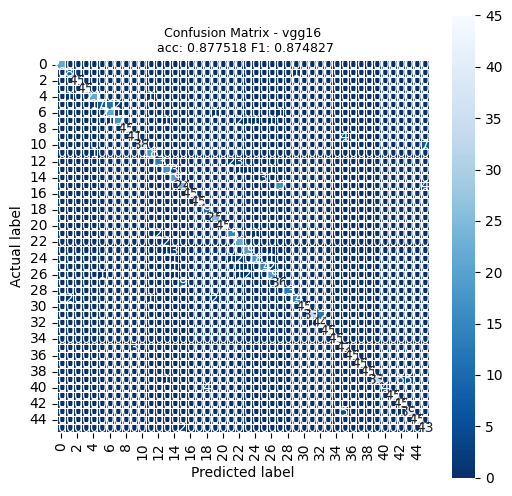

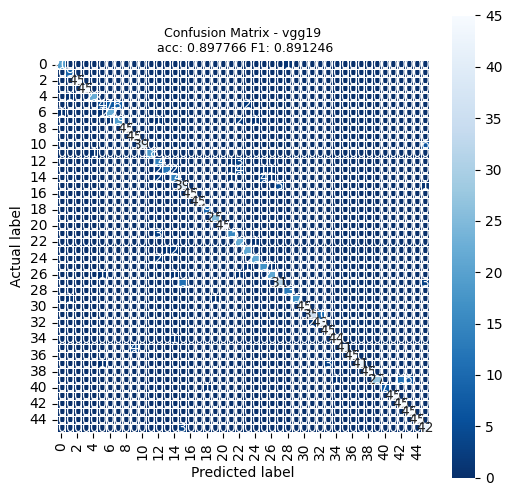

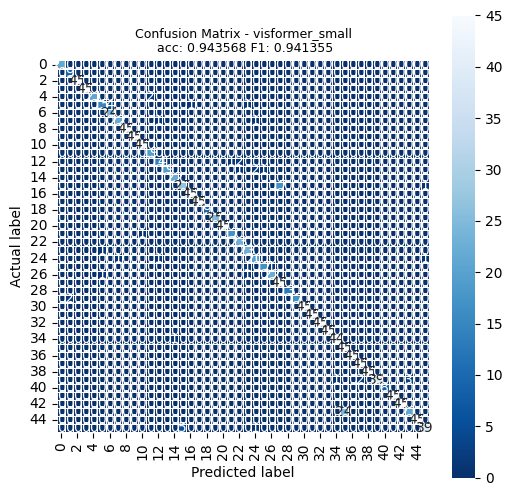

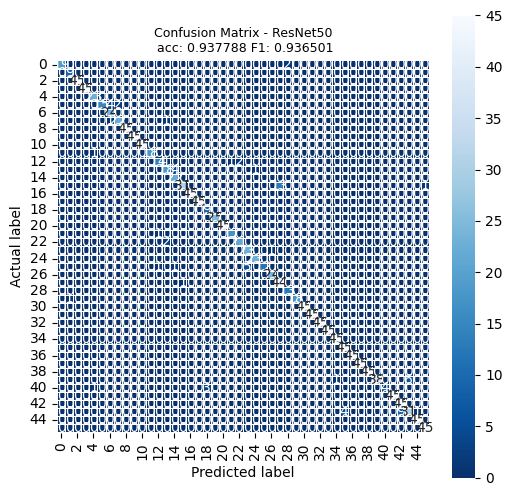

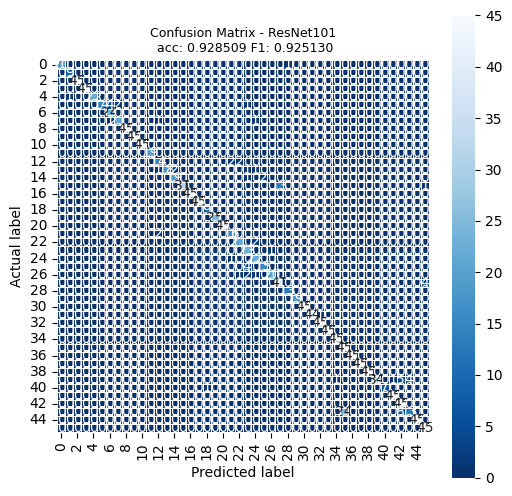

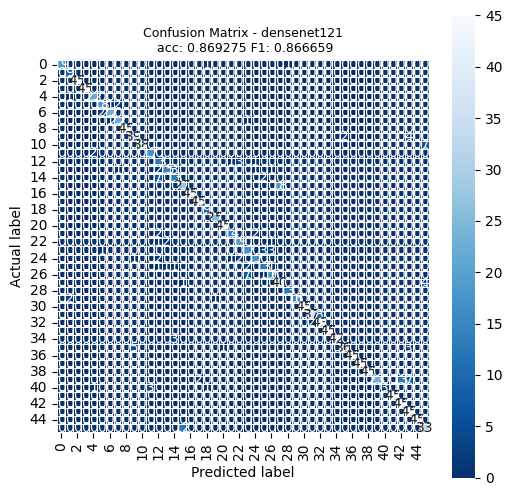

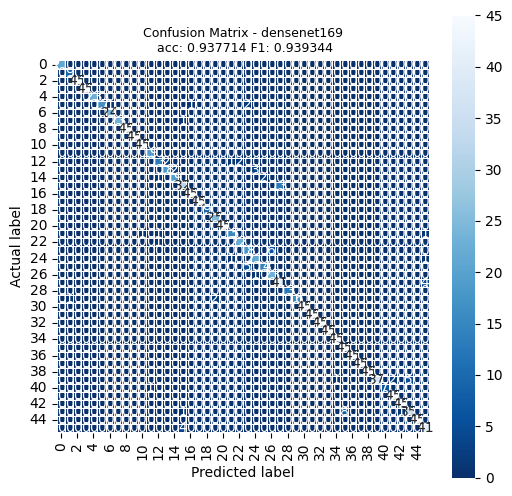

In [5]:
#on colab:
#program_path = "/content/drive/MyDrive/Mestrado/programa_mestrado"
#image_path_train = "/content/drive/MyDrive/Mestrado/programa_mestrado/imagens/train"
#image_path_val = "/content/drive/MyDrive/Mestrado/programa_mestrado/imagens/val"
program_path = "."
image_path_train = "./images/train"
image_path_val = "./images/val"
image_path_test = "./images/test"

# Learning rate for the model
lr = 1e-5
# Number of training epochs
epochs = 30

#if os.path.exists("./runs"):
#    del_file("./runs")  # clear the runs folder, NOTICE this may be DANGEROUS
#else:
#    os.makedirs("./runs")


#if os.path.exists("./models"):
#    del_file("./models")  # clear the models folder, NOTICE this may be DANGEROUS
#else:
#    os.makedirs("./models")

models_to_train = [['vit_base_patch16_384',384]
                    ,['inception_v3',384]
                    ,['xception',384]
                    ,['vgg16',384]
                    ,['vgg19',384]
                    ,['visformer_small',224]
                    ,['ResNet50',384]
                    ,['ResNet101',384]
                    ,['densenet121',224]
                    ,['densenet169',224]
                  ]

for i in models_to_train:          
    training_class_models(program_path,image_path_train,image_path_val,image_path_test,\
        i[0],lr,epochs,i[1]).initiate()
    
    #training_class_models(program_path,image_path_train,image_path_val,image_path_test,\
    #    i[0],lr,epochs,i[1]).test_with_saved_model()

